## Import modules and functions

In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio

## Define directory of images

In [2]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Controls/20190908_fixedctrl/' #master folder

## Make dictionary for storing results

In [3]:
results = {"filename":[],"exp":[],
           "Manual mask from matlab GUI":[],"bg sub int under mask":[]}
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if filelist[i].endswith(".nd2"): 
        results["filename"].append(filelist[i])
        results["exp"].append(filelist[i].split('/')[-2])

## Read manual masks from Matlab GUI

In [4]:
## matlab files
for im in range(0,len(results["filename"])): 
    file=results["filename"][im][:-4]+'_mask.mat'
    from pathlib import Path
    my_file = Path(file)
    if my_file.exists():
        print(file)
        mat = spio.loadmat(file, squeeze_me=True)
        mask=mat['totMask']>0.99
        results["Manual mask from matlab GUI"].append(mask)
    else:
        results["Manual mask from matlab GUI"].append(np.nan)
clear_output()        
print("Done!")

Done!


## Batch analysis of images - mean intensity

In [5]:
print('Total number of images: ' + str(len(results['filename'])))

for i in range(0,len(results["filename"])): 
    flag=False
    print('Calculating image no ' + str(i+1) + ' out of' + str(len(results["filename"])))
    #read the image
    with ND2Reader(results["filename"][i]) as images:
        ecm_image=images[1]
    #convert to numpy array - a format easier to manipunuclei with code
    ecm_image=ecm_image.astype(np.int16)
    #read masks 
    matlab_mask=results["Manual mask from matlab GUI"][i]
    if type(matlab_mask)==np.ndarray:
        flag=True
    #image after background subtraction
    #for ecm image
    if flag==True:
        ecm_matlabmasked_bgreduced=deepcopy(ecm_image)
        bg_matlabmask=np.mean(ndi.median_filter(ecm_image[matlab_mask],size=5))+0*np.std(ndi.median_filter(ecm_image[matlab_mask],size=5))
        ecm_matlabmasked_bgreduced=np.subtract(ecm_matlabmasked_bgreduced,bg_matlabmask)
        ecm_matlabmasked_bgreduced[ecm_matlabmasked_bgreduced<0]=0
        ecm_matlabmasked_bgreduced[~matlab_mask]=0
        
    if flag==True:
        results["bg sub int under mask"].append(ecm_matlabmasked_bgreduced[matlab_mask].mean())
    else:
        results["bg sub int under mask"].append(np.nan)

Total number of images: 148
Calculating image no 1 out of148
Calculating image no 2 out of148
Calculating image no 3 out of148
Calculating image no 4 out of148
Calculating image no 5 out of148
Calculating image no 6 out of148
Calculating image no 7 out of148
Calculating image no 8 out of148
Calculating image no 9 out of148
Calculating image no 10 out of148
Calculating image no 11 out of148
Calculating image no 12 out of148
Calculating image no 13 out of148
Calculating image no 14 out of148
Calculating image no 15 out of148
Calculating image no 16 out of148
Calculating image no 17 out of148
Calculating image no 18 out of148
Calculating image no 19 out of148
Calculating image no 20 out of148
Calculating image no 21 out of148
Calculating image no 22 out of148
Calculating image no 23 out of148
Calculating image no 24 out of148
Calculating image no 25 out of148
Calculating image no 26 out of148
Calculating image no 27 out of148
Calculating image no 28 out of148
Calculating image no 29 out o

## Make a dataframe of the results

In [6]:
df=pd.DataFrame(results)
df2=deepcopy(df)
df2['Blocked or not']='None'
df2.loc[df2['exp'].str.contains('blk'), 'Blocked or not'] = 'Blocked'
df2.loc[df2['exp'].str.contains('no'), 'Blocked or not'] = 'Unblocked'

df2['Time']='Immediately'

df2['TNR or secondary']='None'
df2.loc[df2['exp'].str.contains('tnr'), 'TNR or secondary'] = 'TNR'
df2.loc[df2['exp'].str.contains('tnr'), 'TNR or secondary'] = 'TNR'

df2['expno']='None'
df2.loc[df2['filename'].str.contains('exp1'), 'expno'] = 'exp1'
df2.loc[df2['filename'].str.contains('exp2'), 'expno'] = 'exp2'
df2.loc[df2['filename'].str.contains('exp3'), 'expno'] = 'exp3'

df2["Condition"]='None'
df2.loc[df2['filename'].str.contains('background_atto647'), 'Condition'] = 'Background - Atto647'
df2.loc[df2['filename'].str.contains('background_autofluorescence'), 'Condition'] = 'Background - Autofluorescence'
df2.loc[df2['filename'].str.contains('blk_plues12h'), 'Condition'] = 'Block+12, TNR647'
df2.loc[df2['filename'].str.contains('blk_plus0h'), 'Condition'] = 'Block+0, TNR647'
df2.loc[df2['filename'].str.contains('noblock_tnr647'), 'Condition'] = 'Unblocked TNR647'

## Make dataframe with means for individual experiments

In [7]:
var="bg sub int under mask"
means={"expname":[],"Condition":[],"intensity":[]}
df2read=df2
for exp in df2read["expno"].unique():
    dfcalc=df2read[df2read["expno"]==exp]
    dfcalc=dfcalc.reset_index()
    for condition in dfcalc["Condition"].unique():
        dfcalc_cond=dfcalc[dfcalc["Condition"]==condition]
        means["expname"].append(exp)
        means["Condition"].append(condition)
        means["intensity"].append(dfcalc_cond[var].mean())
dfmeans=pd.DataFrame(means)

## Multiple ttests with Bonferroni correction (compare each group to no blocking condition)

In [8]:
from scipy import stats
negctrl=dfmeans[dfmeans["Condition"]=="Unblocked TNR647"]["intensity"].values
for item in ["Background - Autofluorescence","Background - Atto647","Block+0, TNR647","Block+12, TNR647"]:
    vals=dfmeans[dfmeans["Condition"]==item]["intensity"].values
    [stat, pval]=stats.ttest_ind(negctrl,vals)
    print('condition: '+item+' pval: '+str(pval*4))

condition: Background - Autofluorescence pval: 0.0012586940060999518
condition: Background - Atto647 pval: 0.0012577355797483715
condition: Block+0, TNR647 pval: 0.0016709346552018628
condition: Block+12, TNR647 pval: 0.0012487057425321633


In [9]:
var="intensity"
bgauto=dfmeans[dfmeans["Condition"]=="Background - Autofluorescence"][var].dropna().values
bgatto=dfmeans[dfmeans["Condition"]=="Background - Atto647"][var].dropna().values
bgblockplus0=dfmeans[dfmeans["Condition"]=="Block+0, TNR647"][var].dropna().values
bgblockplus12=dfmeans[dfmeans["Condition"]=="Block+12, TNR647"][var].dropna().values
negctrl=dfmeans[dfmeans["Condition"]=="Unblocked TNR647"]["intensity"].dropna().values

stats.f_oneway(bgauto, bgatto, bgblockplus0,bgblockplus12,negctrl)

F_onewayResult(statistic=120.30392961081034, pvalue=2.062334378372081e-08)

In [10]:
import ipywidgets as widgets
from ipywidgets import interact
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
from statsmodels.stats.libqsturng import psturng

x = dfmeans["Condition"]
y = dfmeans[var]
# DataFrame.
mcDate = multi.MultiComparison(y,x)
Results = mcDate.tukeyhsd()
df = pd.DataFrame(data=Results._results_table.data[1:], columns=Results._results_table.data[0])
res=Results
pvals=psturng(np.abs(res.meandiffs / res.std_pairs),len(res.groupsunique), res.df_total)
df["pvals"]=pvals

df

,group1,group2,meandiff,lower,upper,reject,pvals
0,Background - Atto647,Background - Autofluorescence,-0.1396,-51.1559,50.8767,False,0.900
1,Background - Atto647,"Block+0, TNR647",5.6641,-45.3522,56.6804,False,0.900
2,Background - Atto647,"Block+12, TNR647",-0.5246,-51.5409,50.4917,False,0.900
3,Background - Atto647,Unblocked TNR647,269.9668,218.9505,320.9831,True,0.001
4,Background - Autofluorescence,"Block+0, TNR647",5.8037,-45.2126,56.8200,False,0.900
5,Background - Autofluorescence,"Block+12, TNR647",-0.3850,-51.4013,50.6313,False,0.900
6,Background - Autofluorescence,Unblocked TNR647,270.1064,219.0901,321.1227,True,0.001
7,"Block+0, TNR647","Block+12, TNR647",-6.1887,-57.2050,44.8276,False,0.900
8,"Block+0, TNR647",Unblocked TNR647,264.3027,213.2864,315.3190,True,0.001
9,"Block+12, TNR647",Unblocked TNR647,270.4914,219.4751,321.5077,True,0.001


## nice plot

In [11]:
dfmeans

,expname,Condition,intensity
0,exp1,Background - Atto647,16.355005
1,exp1,Background - Autofluorescence,17.467143
2,exp1,"Block+12, TNR647",16.749460
3,exp1,"Block+0, TNR647",37.588116
4,exp1,Unblocked TNR647,298.408752
5,exp2,Background - Atto647,16.439365
6,exp2,Background - Autofluorescence,14.651942
7,exp2,"Block+12, TNR647",15.921725
8,exp2,"Block+0, TNR647",14.941446
9,exp2,Unblocked TNR647,319.551266


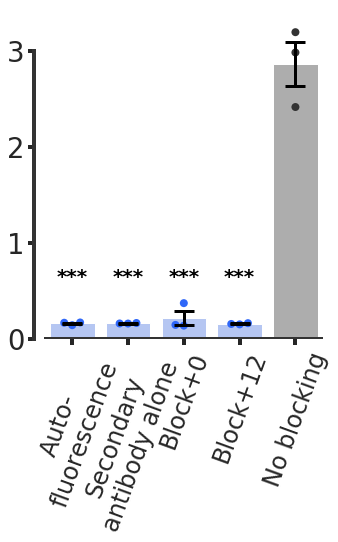

In [15]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker

fig=plt.figure(figsize=(5,6))

df2plot=dfmeans
var='intensity'
order=['Background - Autofluorescence',
       'Background - Atto647',
      'Block+0, TNR647',
       'Block+12, TNR647',
       'Unblocked TNR647'
       ]

paletteswarm ={"Background - Autofluorescence":"#2F67F8",
               "Unblocked TNR647":"#333333",
               "Background - Atto647":"#2F67F8",
               "Block+0, TNR647":"#2F67F8",
               "Block+12, TNR647":"#2F67F8"}
palette ={"Background - Autofluorescence":"#abc2fc",
          "Unblocked TNR647":"#adadad",
               "Background - Atto647":"#abc2fc",
               "Block+0, TNR647":"#abc2fc",
               "Block+12, TNR647":"#abc2fc"}


g=sns.barplot(data=df2plot,y=var,x="Condition"
            ,order=order,palette=palette,ci=None)

g=sns.swarmplot(data=df2plot,y=var,x="Condition"
            ,order=order,palette=paletteswarm,size=8)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        
        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
change_width(g, .8)

plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["Condition"]==condtype][var].mean() for condtype in order],
             yerr=[df2plot[df2plot["Condition"]==condtype][var].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

plt.axhline(0, color='#333333',alpha=1,linewidth=4)

g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)

plt.rcParams['font.sans-serif'] = 'Helvetica'


g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)


g.grid(False)


for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)

plt.xticks(g.get_xticks(),['Auto-\nfluorescence',
                           'Secondary\nantibody alone',
      'Block+0',
       'Block+12',
       'No blocking'
       ],
           rotation=70,size=24)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
#plt.yticks([0,2,4,6,8,10,12],fontsize=22,color='#333333')

for number in range(4):
    plt.text(number, 55, "***", ha='center', va='bottom', color=col,size=20, weight='bold')


scale_x=100
ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}' .format(x/scale_x))
g=plt.gca()
g.yaxis.set_major_formatter(ticks_y)

#plt.ylim([0,12.5])
'''x1, x2 = 0,4
y= 330
h=5
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=24, weight='bold')

x1, x2 = 1,4
y= 330
h=5
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)

x1, x2 = 2,4
y= 330
h=5
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)

x1, x2 = 3,4
y= 330
h=5
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)'''


diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"

fig.savefig(diri+'supp1_fixedctrl.svg', bbox_inches='tight', format='svg')









